# Dask for Predicting Onset/Diagnosis of Chronic Conditions, Diabetes

- categories: [Big Data]

## Credit: http://matthewrocklin.com/blog/work/2017/03/28/dask-xgboost, https://examples.dask.org/applications/forecasting-with-prophet.html

In [ ]:
import dask
from dask.distributed import Client, progress

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)

client

Client Scheduler: tcp://127.0.0.1:41309 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.57 GB


In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/davidrkearney/colab-notebooks/main/datasets/diabetes.csv'
df = pd.read_csv(url, error_bad_lines=False)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
from dask import dataframe as dd 

ddf = dd.from_pandas(df, npartitions=5)

ddf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
npartitions=5,,,,,,,,,
0,int64,int64,int64,int64,int64,float64,float64,int64,int64
154,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
616,...,...,...,...,...,...,...,...,...
767,...,...,...,...,...,...,...,...,...


In [10]:
import dask.dataframe as dd

# Subset of the columns to use
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [11]:
ddf2 = ddf.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster

In [12]:
ddf2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
npartitions=5,,,,,,,,,
0,int64,int64,int64,int64,int64,float64,float64,int64,int64
154,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
616,...,...,...,...,...,...,...,...,...
767,...,...,...,...,...,...,...,...,...


In [13]:
diab_diag = (ddf.Outcome)  # column of labels

In [14]:
del ddf['Outcome']  # Remove delay information from training dataframe

In [15]:
ddf, diab_diag = dask.persist(ddf, diab_diag)  # start work in the background

In [16]:
diab_diag.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [17]:
df2 = dd.get_dummies(ddf.categorize()).persist()

In [18]:
len(df2.columns)

8

In [20]:
data_train, data_test = df2.random_split([0.9, 0.1],
                                         random_state=1234)
labels_train, labels_test = diab_diag.random_split([0.9, 0.1],
                                                    random_state=1234)

In [21]:
%%time
import dask_xgboost as dxgb

params = {'objective': 'binary:logistic', 'nround': 1000,
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 1, 'tree_method': 'hist',
          'grow_policy': 'lossguide'}

bst = dxgb.train(client, params, data_train, labels_train)

CPU times: user 1.23 s, sys: 607 ms, total: 1.84 s
Wall time: 3.56 s


In [22]:
bst

In [23]:
import xgboost as xgb
pandas_df = data_test.head()
dtest = xgb.DMatrix(pandas_df)

In [24]:
bst.predict(dtest)

array([0.52612805, 0.51560616, 0.47321838, 0.5084377 , 0.45707062],
      dtype=float32)

In [25]:
predictions = dxgb.predict(client, bst, data_test).persist()

In [26]:
predictions

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

In [29]:
print(roc_auc_score(labels_test.compute(), predictions.compute()))

0.7775157232704403


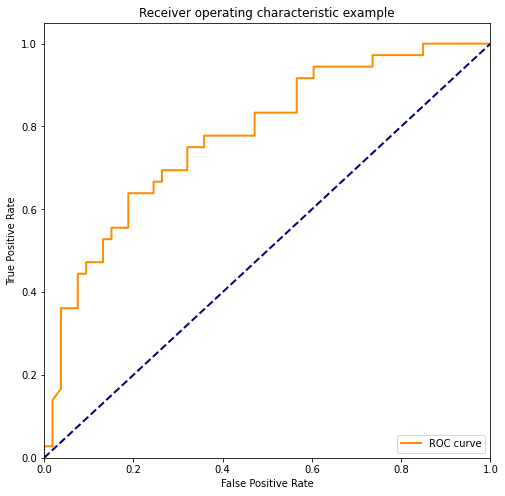

In [31]:
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(labels_test.compute(), predictions.compute())
# Taken from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [35]:
import dask
import xgboost
import dask_xgboost

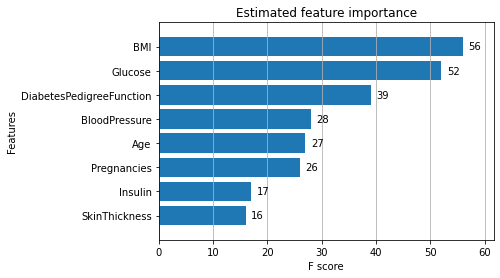

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [38]:
y_hat = dask_xgboost.predict(client, bst, data_test).persist()
y_hat

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [42]:
from sklearn.metrics import roc_curve

labels_test, y_hat = dask.compute(labels_test, y_hat)
fpr, tpr, _ = roc_curve(labels_test, y_hat)

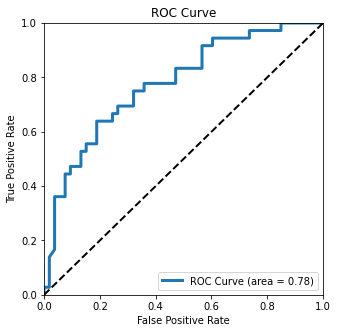

In [43]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()